# 1. 近似牛顿法
由割线条件推导出Hessian的近似方法，然后引入BFGS条件，然后得到更新矩阵 $B_{k+1}$
接着使用 非精确线搜索 来 满足寻找Wolfe的步长t，然后使用Cautious——BFGS计算B，用B来更新，直到收敛。

## 2. Julia实现Quasi-Newton方法可视化

下面将使用Julia语言实现对函数 $f(x) = (1 - x_1)^2 + (x_2 - x_1^2)^2$ 的拟牛顿（Quasi-Newton）方法优化过程的可视化。  
主要步骤包括：

- 使用Cautious-BFGS更新Hessian近似矩阵
- 采用非精确线搜索（inexact line search）以满足Wolfe条件
- 初始点设为 $(1, 1)$
- 绘制优化路径和等高线图，直观展示迭代过程

代码实现详见下方代码单元。

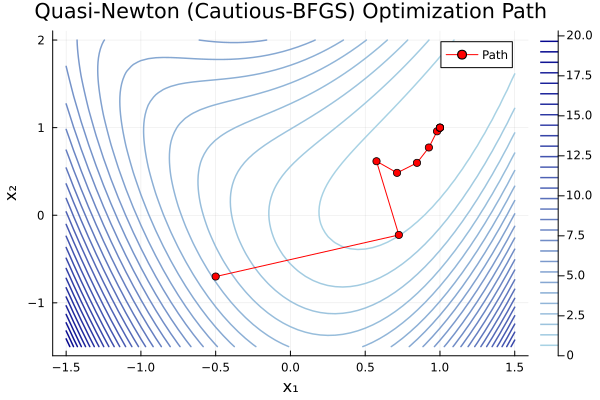

In [4]:
using LinearAlgebra, Plots

# 定义目标函数和梯度
function f(x)
    return (1 - x[1])^2 + (x[2] - x[1]^2)^2
end

function grad_f(x)
    df1 = -2 * (1 - x[1]) - 4 * x[1] * (x[2] - x[1]^2)
    df2 = 2 * (x[2] - x[1]^2)
    return [df1, df2]
end

# Wolfe条件的inexact line search
function wolfe_line_search(f, grad_f, x, p; c1=1e-4, c2=0.9, alpha0=1.0)
    alpha = alpha0
    phi0 = f(x)
    dphi0 = dot(grad_f(x), p)
    while true
        x_new = x + alpha * p
        if f(x_new) > phi0 + c1 * alpha * dphi0
            alpha *= 0.5
        elseif dot(grad_f(x_new), p) < c2 * dphi0
            alpha *= 1.1
        else
            break
        end
        if alpha < 1e-8
            break
        end
    end
    return alpha
end

# Cautious-BFGS更新
function cautious_bfgs(B, s, y; θ=0.2)
    if dot(s, y) >= θ * norm(s) * norm(y)
        Bs = B * s
        sy = dot(s, y)
        sBs = dot(s, Bs)
        B_new = B - Bs * Bs' / sBs + y * y' / sy
        return B_new
    else
        return B
    end
end

# Quasi-Newton主循环
function quasi_newton(f, grad_f, x0; maxiter=50, tol=1e-6)
    x = x0
    B = I(2)
    path = [x0]
    for k in 1:maxiter
        g = grad_f(x)
        if norm(g) < tol
            break
        end
        p = -B \ g
        α = wolfe_line_search(f, grad_f, x, p)
        s = α * p
        x_new = x + s
        y = grad_f(x_new) - g
        B = cautious_bfgs(B, s, y)
        x = x_new
        push!(path, x)
    end
    return path
end

# 运行算法
x0 = [-0.5, -0.7]
path = quasi_newton(f, grad_f, x0)

# 可视化
x1 = -1.5:0.05:1.5
x2 = -1.5:0.05:2.0
Z = [f([x, y]) for x in x1, y in x2]
contour(x1, x2, Z', levels=30, linewidth=1.5, c=:blues, xlabel="x₁", ylabel="x₂", title="Quasi-Newton (Cautious-BFGS) Optimization Path")
xs = [p[1] for p in path]
ys = [p[2] for p in path]
plot!(xs, ys, marker=:circle, color=:red, label="Path", legend=:topright)

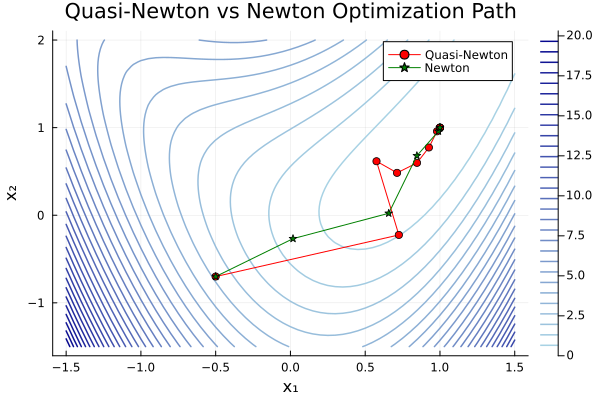

In [ ]:
# 牛顿法主循环
function newton_method(f, grad_f, x0; maxiter=50, tol=1e-6)
    x = x0
    path = [x0]
    for k in 1:maxiter
        g = grad_f(x)
        if norm(g) < tol
            break
        end
        # Hessian for Rosenbrock function
        H = [
            2 - 4 * x[2] + 12 * x[1]^2  -4 * x[1];
            -4 * x[1]                   2
        ]
        p = -H \ g
        α = wolfe_line_search(f, grad_f, x, p)
        x_new = x + α * p
        x = x_new
        push!(path, x)
    end
    return path
end

# 运行牛顿法
path_newton = newton_method(f, grad_f, x0)

# 可视化
contour(x1, x2, Z', levels=30, linewidth=1.5, c=:blues, xlabel="x₁", ylabel="x₂", title="Quasi-Newton vs Newton Optimization Path")
xs = [p[1] for p in path]
ys = [p[2] for p in path]
plot!(xs, ys, marker=:circle, color=:red, label="Quasi-Newton", legend=:topright)

xs_n = [p[1] for p in path_newton]
ys_n = [p[2] for p in path_newton]
plot!(xs_n, ys_n, marker=:star5, color=:green, label="Newton")


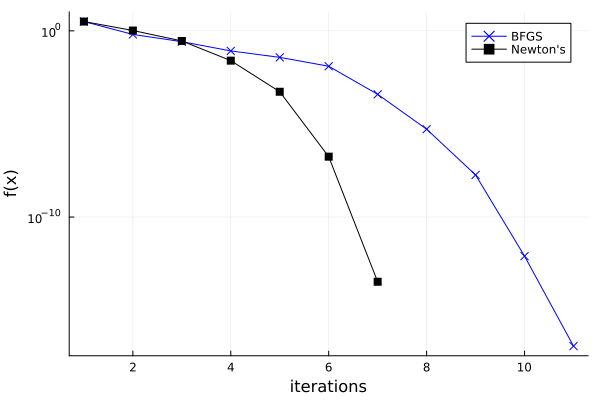

In [8]:
# 计算每次迭代的函数值
fvals_bfgs = [f(x) for x in path]
fvals_newton = [f(x) for x in path_newton]

# 绘制对数坐标下的函数值收敛曲线
plot(1:length(fvals_bfgs), fvals_bfgs; yscale=:log10, marker=:x, color=:blue, label="BFGS", xlabel="iterations", ylabel="f(x)", legend=:topright)
plot!(1:length(fvals_newton), fvals_newton; marker=:square, color=:black, label="Newton's")

- **Cautious-BFGS** 在每次迭代时都维护并更新一个完整的Hessian近似矩阵 $B_k$，但只有当 $s^T y$ 满足谨慎条件（如 $s^T y \geq \theta \|s\|\|y\|$）时才执行BFGS更新，否则保持 $B_k$ 不变。这种做法保证了Hessian近似的数值稳定性。每步都需要存储和操作 $n \times n$ 的矩阵，适合变量维数较小的情形。

- **L-BFGS** 不直接维护或更新完整的Hessian近似矩阵，而是仅保存最近 $m$ 对 $(s, y)$ 向量。每次计算搜索方向时，通过两次循环递推算法（two-loop recursion）利用这 $m$ 对历史信息近似作用于梯度，间接获得 $B_k^{-1} \nabla f(x_k)$。这样极大节省了内存和计算量，适合变量维数很大的情形。

算法流程上，Cautious-BFGS每步都更新/维护完整矩阵，L-BFGS则只维护有限历史向量并用递推公式计算方向，二者本质不同。


### L-BFGS算法伪代码

1. 初始化 $x_0$，设置历史长度 $m$，清空$s$/$y$历史队列
2. 对 $k=0,1,2,\ldots$ 直到收敛：
    1. 计算当前梯度 $g_k = \nabla f(x_k)$
    2. 若 $\|g_k\| < \text{tol}$，停止
    3. 两次循环递推计算搜索方向 $p_k$：
        - 设 $q = g_k$
        - **第一循环（从后往前）**  
          对 $i = \text{len}(s)-1, ..., 0$：
            - $\rho_i = 1 / (y_i^T s_i)$
            - $\alpha_i = \rho_i s_i^T q$
            - $q = q - \alpha_i y_i$
        - 设 $H_0 = \gamma I$，其中 $\gamma = \frac{s_{-1}^T y_{-1}}{y_{-1}^T y_{-1}}$（若历史为空则$\gamma=1$）
        - $r = H_0 q$
        - **第二循环（从前往后）**  
          对 $i = 0, ..., \text{len}(s)-1$：
            - $\rho_i = 1 / (y_i^T s_i)$
            - $\beta = \rho_i y_i^T r$
            - $r = r + s_i (\alpha_i - \beta)$
        - $p_k = -r$
    4. 用Wolfe线搜索确定步长 $\alpha_k$
    5. 更新 $s_k = \alpha_k p_k$，$x_{k+1} = x_k + s_k$，$y_k = \nabla f(x_{k+1}) - g_k$
    6. 若历史队列已满，移除最早的$s$/$y$对
    7. 将 $s_k, y_k$ 加入历史队列
3. 返回优化路径

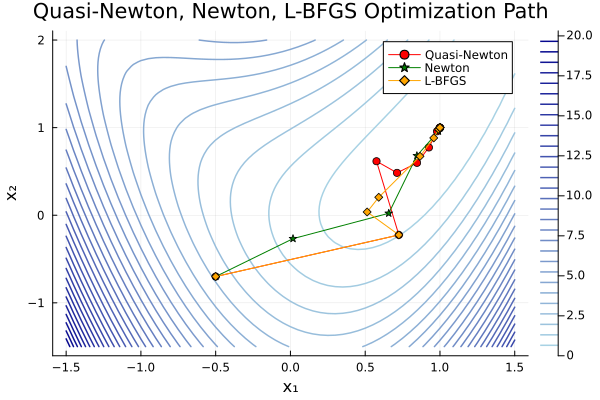

In [9]:
# L-BFGS主循环
function lbfgs(f, grad_f, x0; m=5, maxiter=50, tol=1e-6)
    x = x0
    path = [x0]
    s_list = Vector{Vector{Float64}}()
    y_list = Vector{Vector{Float64}}()
    ρ_list = Float64[]
    g_prev = grad_f(x)
    for k in 1:maxiter
        g = grad_f(x)
        if norm(g) < tol
            break
        end
        q = g
        αs = Float64[]
        for i = length(s_list):-1:1
            s = s_list[i]
            y = y_list[i]
            ρ = 1 / dot(y, s)
            α = ρ * dot(s, q)
            pushfirst!(αs, α)
            q -= α * y
        end
        # 初始化H0为单位阵的缩放
        if !isempty(y_list)
            γ = dot(s_list[end], y_list[end]) / dot(y_list[end], y_list[end])
        else
            γ = 1.0
        end
        r = γ * q
        for i = 1:length(s_list)
            s = s_list[i]
            y = y_list[i]
            ρ = 1 / dot(y, s)
            β = ρ * dot(y, r)
            r += s * (αs[i] - β)
        end
        p = -r
        α_step = wolfe_line_search(f, grad_f, x, p)
        s = α_step * p
        x_new = x + s
        y = grad_f(x_new) - g
        # 更新历史
        if length(s_list) == m
            popfirst!(s_list)
            popfirst!(y_list)
        end
        push!(s_list, s)
        push!(y_list, y)
        x = x_new
        push!(path, x)
    end
    return path
end

# 运行L-BFGS
path_lbfgs = lbfgs(f, grad_f, x0)

# 可视化
contour(x1, x2, Z', levels=30, linewidth=1.5, c=:blues, xlabel="x₁", ylabel="x₂", title="Quasi-Newton, Newton, L-BFGS Optimization Path")
xs = [p[1] for p in path]
ys = [p[2] for p in path]
plot!(xs, ys, marker=:circle, color=:red, label="Quasi-Newton", legend=:topright)

xs_n = [p[1] for p in path_newton]
ys_n = [p[2] for p in path_newton]
plot!(xs_n, ys_n, marker=:star5, color=:green, label="Newton")

xs_l = [p[1] for p in path_lbfgs]
ys_l = [p[2] for p in path_lbfgs]
plot!(xs_l, ys_l, marker=:diamond, color=:orange, label="L-BFGS")

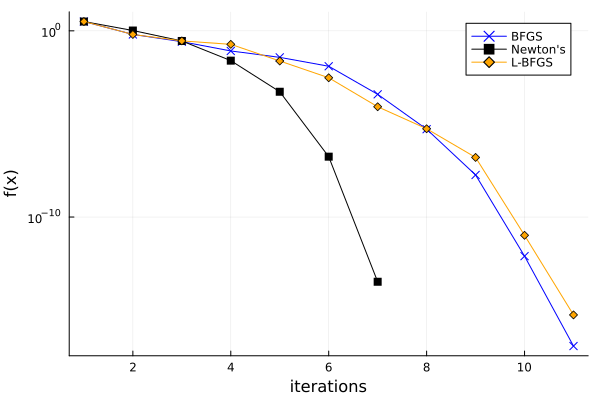

In [10]:
# 计算L-BFGS每次迭代的函数值
fvals_lbfgs = [f(x) for x in path_lbfgs]

# 绘制三种方法的对数坐标收敛曲线
plot(1:length(fvals_bfgs), fvals_bfgs; yscale=:log10, marker=:x, color=:blue, label="BFGS", xlabel="iterations", ylabel="f(x)", legend=:topright)
plot!(1:length(fvals_newton), fvals_newton; marker=:square, color=:black, label="Newton's")
plot!(1:length(fvals_lbfgs), fvals_lbfgs; marker=:diamond, color=:orange, label="L-BFGS")

In [12]:
# Lewis & Overton 弱Wolfe线搜索（无插值）
function weak_wolfe_line_search(f, grad_f, x, d; c1=1e-4, c2=0.9, α0=1.0)
    l = 0.0
    u = Inf
    α = α0
    φ0 = f(x)
    dφ0 = dot(grad_f(x), d)
    while true
        x_new = x + α * d
        # S(α): Sufficient decrease (weak Wolfe)
        if f(x_new) - φ0 < -c1 * α * dφ0
            u = α
        # C(α): Curvature condition (weak Wolfe)
        elseif dot(grad_f(x_new), d) < c2 * dφ0
            l = α
        else
            return α
        end
        if u < Inf
            α = (l + u) / 2
        else
            α = 2l
        end
        if α < 1e-12 || α > 1e12
            break
        end
    end
    return α
end

weak_wolfe_line_search (generic function with 1 method)

In [ ]:
# 可视化Lewis & Overton弱Wolfe线搜索过程（仿照图中左侧示意图）

# 构造一个非光滑的1D目标函数
function nonsmooth_f(x)
    return abs(x + 0.7) + 0.3 * sin(5x)
end

function nonsmooth_grad(x)
    # 次梯度
    g = sign(x + 0.7) + 0.3 * 5 * cos(5x)
    return g
end

f1d = nonsmooth_f
grad1d = nonsmooth_grad

x0 = -2.0
d = 1.0  # 搜索方向

alphas = Float64[]
fvals = Float64[]
l_hist = Float64[]
u_hist = Float64[]

l = 0.0
u = Inf
α = 1.0
φ0 = f1d(x0)
dφ0 = grad1d(x0) * d
c1 = 1e-4
c2 = 0.9

# 记录搜索过程
for i in 1:10
    push!(alphas, α)
    push!(fvals, f1d(x0 + α * d))
    push!(l_hist, l)
    push!(u_hist, isfinite(u) ? u : NaN)
    x_new = x0 + α * d
    # S(α): Sufficient decrease (weak Wolfe)
    if f1d(x_new) - φ0 < -c1 * α * dφ0
        u = α
    # C(α): Curvature condition (weak Wolfe)
    elseif grad1d(x_new) < c2 * dφ0
        l = α
    else
        break
    end
    if u < Inf
        α = (l + u) / 2
    else
        α = 2l
    end
    if α < 1e-8 || α > 10
        break
    end
end

# 绘制目标函数和搜索过程
xs = -2:0.01:2
ys = [f1d(x) for x in xs]
plot(xs, ys, lw=2, label="f(x)", xlabel="x", ylabel="f(x)", title
sca
for (i,
    annotate!(x0 + α, fvals[i], text("α$(i)", :red, 8))
end
# 可视化l, u区间
for i in 1:
   
        plot!([x0 + l_hist[i], x0 + u_hist[i]], [minimu
    end
endm(ys)-0.2, minimum(ys)-0.2], lw=4, color=:purple, label=(i==1 ? "interval [l, u]" : "")) if !isnan(u_hist[i])length(l_hist) α) in enumerate(alphas)tter!(x0 .+ alphas, fvals, color=:red, marker=:circle, label="search points")="Lewis & Overton Weak Wolfe Line Search (1D)", legend=:topright)# 可视化Lewis & Overton弱Wolfe线搜索过程（仿照图中左侧示意图）

# 构造一个非光滑的1D目标函数
function nonsmooth_f(x)
    return abs(x + 0.7) + 0.3 * sin(5x)
end

function nonsmooth_grad(x)
    # 次梯度
    g = sign(x + 0.7) + 0.3 * 5 * cos(5x)
    return g
end

f1d = nonsmooth_f
grad1d = nonsmooth_grad

x0 = -2.0
d = 1.0  # 搜索方向

alphas = Float64[]
fvals = Float64[]
l_hist = Float64[]
u_hist = Float64[]

l = 0.0
u = Inf
α = 1.0
φ0 = f1d(x0)
dφ0 = grad1d(x0) * d
c1 = 1e-4
c2 = 0.9

# 记录搜索过程
for i in 1:10
    push!(alphas, α)
    push!(fvals, f1d(x0 + α * d))
    push!(l_hist, l)
    push!(u_hist, isfinite(u) ? u : NaN)
    x_new = x0 + α * d
    # S(α): Sufficient decrease (weak Wolfe)
    if f1d(x_new) - φ0 < -c1 * α * dφ0
        u = α
    # C(α): Curvature condition (weak Wolfe)
    elseif grad1d(x_new) < c2 * dφ0
        l = α
    else
        break
    end
    if u < Inf
        α = (l + u) / 2
    else
        α = 2l
    end
    if α < 1e-8 || α > 10
        break
    end
end

# 绘制目标函数和搜索过程
xs = -2:0.01:2
ys = [f1d(x) for x in xs]
plot(xs, ys, lw=2, label="f(x)", xlabel="x", ylabel="f(x)", title
end
    end
        plot!([x0 + l_hist[i], x0 + u_hist[i]], [minimum(ys)-0.2, minimum(ys)-0.2], lw=4, color=:purple, label=(i==1 ? "interval [l, u]" : ""))
    if !isnan(u_hist[i])
for i in 1:length(l_hist)
# 可视化l, u区间
end
    annotate!(x0 + α, fvals[i], text("α$(i)", :red, 8))
for (i, α) in enumerate(alphas)
scatter!(x0 .+ alphas, fvals, color=:red, marker=:circle, label="search points")="Lewis & Overton Weak Wolfe Line Search (1D)", legend=:topright)# 可视化Lewis & Overton弱Wolfe线搜索过程（仿照图中左侧示意图）

# 构造一个非光滑的1D目标函数
function nonsmooth_f(x)
    return abs(x + 0.7) + 0.3 * sin(5x)
end

function nonsmooth_grad(x)
    # 次梯度
    g = sign(x + 0.7) + 0.3 * 5 * cos(5x)
    return g
end

f1d = nonsmooth_f
grad1d = nonsmooth_grad

x0 = -2.0
d = 1.0  # 搜索方向

alphas = Float64[]
fvals = Float64[]
l_hist = Float64[]
u_hist = Float64[]

l = 0.0
u = Inf
α = 1.0
φ0 = f1d(x0)
dφ0 = grad1d(x0) * d
c1 = 1e-4
c2 = 0.9

# 记录搜索过程
for i in 1:10
    push!(alphas, α)
    push!(fvals, f1d(x0 + α * d))
    push!(l_hist, l)
    push!(u_hist, isfinite(u) ? u : NaN)
    x_new = x0 + α * d
    # S(α): Sufficient decrease (weak Wolfe)
    if f1d(x_new) - φ0 < -c1 * α * dφ0
        u = α
    # C(α): Curvature condition (weak Wolfe)
    elseif grad1d(x_new) < c2 * dφ0
        l = α
    else
        break
    end
    if u < Inf
        α = (l + u) / 2
    else
        α = 2l
    end
    if α < 1e-8 || α > 10
        break
    end
end

# 绘制目标函数和搜索过程
xs = -2:0.01:2
ys = [f1d(x) for x in xs]
plot(xs, ys, lw=2, label="f(x)", xlabel="x", ylabel="f(x)", title="Lewis & Overton

Base.Meta.ParseError: ParseError:
# Error @ /Users/lyu/Library/CloudStorage/OneDrive-stud.tu-darmstadt.de/TUDarmstadt/Vierte/lectures/OptimalControl/cmu/notice/mycode/RobustControl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:63:1
plot(xs, ys, lw=2, label="f(x)", xlabel="x", ylabel="f(x)", title
scatter!(x0 .+ alphas, fvals, color=:red, marker=:circle, label="search points")
└─────────────────────────────────────────────────────────────────────────────┘ ── Expected `)`